# CNN for HCM Classification

## Importing necessary dependencies

In [1]:
# Necessary Dependencies
import random
import ipynb.fs.full.HCM_Functions as HCM

from scipy import ndimage
from scipy import stats
import sklearn as skl
from sklearn import model_selection as m_s
from skimage.transform import rescale

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline 

import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)

import glob
import os
from os import listdir

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Pillow Version: 8.1.0


In [2]:
# Check to see if tensorflow detects GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Importing Data

In [3]:
# Load training images into directory
trainingpath = '/home/beepul/HCM-Project/NewROI_4ChamberCine/Training'
TopDirectory = listdir(trainingpath)

In [4]:
# Load in training table
training_df = pd.read_excel('/home/beepul/HCM-Project/HCM_Methods_Data/OrganizedData/Training.xls')
training_df.head()

,PatientNumber,RowSpacing,ColumnSpacing,Xres,Yres,X_Length,Y_Length,Outcome
0,101,1.25000,1.25000,151,151,188.75000,188.75000,0
1,103,1.25000,1.25000,137,137,171.25000,171.25000,0
2,106,1.40625,1.40625,115,115,161.71875,161.71875,0
3,107,1.25000,1.25000,135,135,168.75000,168.75000,0
4,108,1.40625,1.40625,153,153,215.15625,215.15625,1


In [5]:
# Create data frame to store relevant properties of each patient/image
num_patients = training_df.shape[0]
Images = [];
for i in range(num_patients):
    patient = training_df.PatientNumber[i]
    imagepath = trainingpath + '/' + str(patient)
    image_dir = listdir(imagepath)
    num_frames = len(image_dir)
    img_data = np.zeros((training_df.Yres[i],training_df.Xres[i],num_frames))
    for k in range(num_frames):
        framepath = imagepath + '/' + str(k+1) + '.png'
        img_data[:,:,k] = np.asarray(Image.open(framepath))
    Images.append(img_data)

In [6]:
# Store Images in data frame
training_df['Image'] = Images

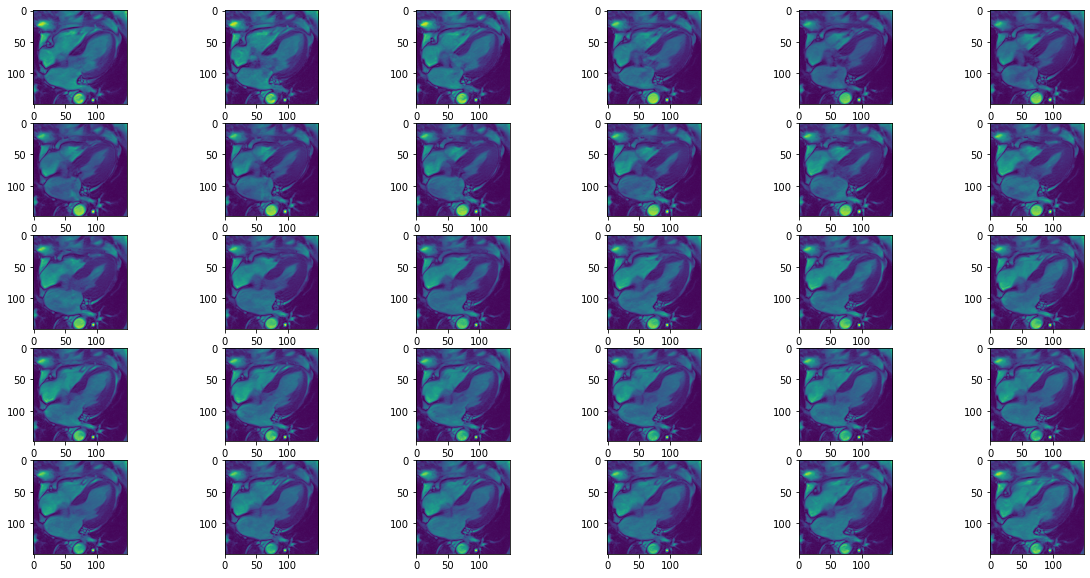

In [7]:
# Load random montage to ensure the images loaded in correctly
volume = training_df.Image[14]
plt.figure(figsize=(20,10))
columns = 6
for i in range(volume.shape[2]):
    image = volume[:,:,i]
    plt.subplot(5, columns, i + 1)
    plt.imshow(image)

## Data Augmentation

(array([ 2., 10., 16., 74., 68., 87., 62., 31., 12.,  7.]),
 array([130.   , 139.625, 149.25 , 158.875, 168.5  , 178.125, 187.75 ,
        197.375, 207.   , 216.625, 226.25 ]),
 <BarContainer object of 10 artists>)

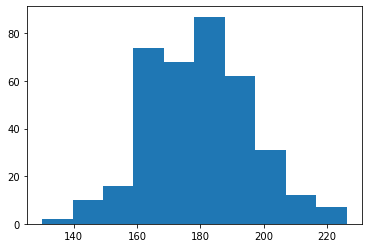

In [8]:
## Histogram of y_lengths
# This suggests that we may need to correct the padding. The largest length
# seems like an outlier and is most likely making us pad the other images too much
plt.hist(training_df.Y_Length)

(array([ 2., 10., 16., 74., 68., 87., 62., 31., 12.,  7.]),
 array([130.   , 139.625, 149.25 , 158.875, 168.5  , 178.125, 187.75 ,
        197.375, 207.   , 216.625, 226.25 ]),
 <BarContainer object of 10 artists>)

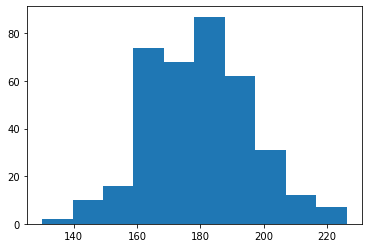

In [9]:
## Histogram of x_lengths
# This suggests that we may need to correct the padding. The largest length
# seems like an outlier and is most likely making us pad the other images too much
plt.hist(training_df.Y_Length)

In [10]:
# Fine largest image within the training set
max_x, max_y = training_df.X_Length.max(), training_df.Y_Length.max()
max_l = np.max([max_x,max_y])

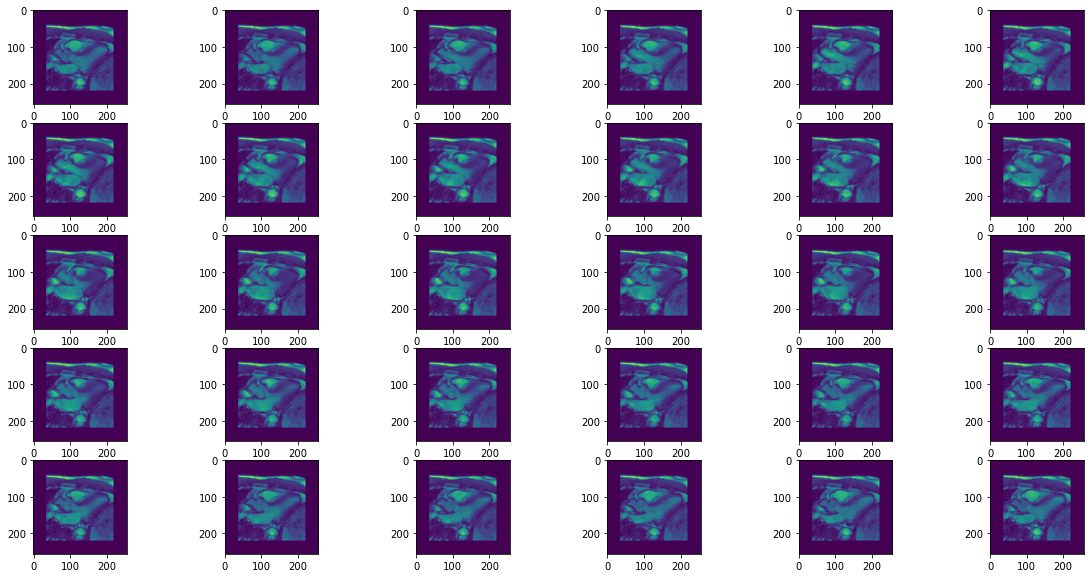

In [11]:
# Load random montage to ensure the padding works correctly
Image = training_df.Image[2]
resized_image = HCM.pad(Image,256,256,training_df.Y_Length[2],max_l)
volume = resized_image
plt.figure(figsize=(20,10))
columns = 6
for i in range(volume.shape[2]):
    image = volume[:,:,i]
    plt.subplot(5, columns, i + 1)
    plt.imshow(image)

In [12]:
# Create empty arrays to store images and labels
training_images = np.empty((training_df.shape[0],256,256,30))
training_labels = np.empty(training_df.shape[0])

In [13]:
# Fill the arrays with the images properly padded and processed
# Each image in training_images is 256 x 256 x 30

index = []
for i in range(training_df.shape[0]):
    image = np.copy(training_df.Image[i])
    training_labels[i] = training_df.Outcome[i]
    index.append(i)
    padded_image = HCM.pad(image,256,256,training_df.Y_Length[i],max_l)
    if padded_image.shape[2] == 50:
        training_images[i] =  HCM.frame_selection(padded_image)
    else:
        training_images[i] = padded_image

In [14]:
## Make validation set
## Stratified set
sss = m_s.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, val_index in sss.split(training_images, training_labels):
    print("TRAIN Size:", len(train_index), "Val Size:", len(val_index))

TRAIN Size: 295 Val Size: 74


In [15]:
# Making the training and validation sets
sub_train_images, sub_train_labels = training_images[train_index], training_labels[train_index]
val_images, val_labels = training_images[val_index], training_labels[val_index]

In [16]:
# Load the images and labels into proper tensor format
train_loader = tf.data.Dataset.from_tensor_slices((sub_train_images, sub_train_labels))
validation_loader = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

In [17]:
# Function to add 4th dimension to image
def add_dim(image, label):
    """Process image by adding a channel."""
    processed_image = tf.expand_dims(image, axis=3)
    return processed_image, label

In [18]:
batch_size = 5
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(sub_train_images))
    .map(add_dim)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(val_images))
    .map(add_dim)
    .batch(batch_size)
    .prefetch(2)
)

## CNN

In [19]:
# Currently Assuming that the input images are 150x150 with 30 frames
# Channel = 1 because they are grayscale
# This architecure is DEFINITELY subject to change

# Input Data
input_data = layers.Input([256,256,30,1])
initializer1 = tf.keras.initializers.he_normal()
initializer2 = tf.keras.initializers.GlorotNormal()

# Conv 1.1
encoder = Conv3D(4,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(input_data)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = Conv3D(4,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = MaxPooling3D(pool_size = (2,2,2), strides=(2,2,2))(encoder)

# Conv 2.1
encoder = Conv3D(8,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = Conv3D(8,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = MaxPooling3D(pool_size = (2,2,3), strides=(2,2,3))(encoder)

# Conv 3.1
encoder = Conv3D(16,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = Conv3D(16,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = MaxPooling3D(pool_size = (4,4,5), strides=(4,4,5), padding = "same")(encoder)

# Size of data after convolutional layers
volumesize = tf.keras.backend.int_shape(encoder)

# Fully Connected
# 1st layer
encoder = Flatten()(encoder)
dense1_size = tf.keras.backend.int_shape(encoder)

# 2nd layer
encoder = layers.Dense(100,activation = 'relu', kernel_initializer = initializer1)(encoder)

# Classifying layer
encoder_cnn = layers.Dense(1,activation = 'sigmoid', kernel_initializer = initializer2)(encoder)

In [20]:
# Summary of the encoder 
model = tf.keras.Model(input_data, encoder_cnn, name="HCM_CNN")
model.summary()

Model: "HCM_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 30, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 256, 256, 30, 4)   112       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 30, 4)   16        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 256, 256, 30, 4)   436       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 30, 4)   16        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 128, 128, 15, 4)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 128, 128, 15, 8)   872 

In [21]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

In [22]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg = len(training_labels[training_labels == 0])
pos = len(training_labels[training_labels == 1])
total = len(training_labels)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.59


In [23]:
# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 10
model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
    class_weight = class_weight
)

Epoch 1/10
59/59 - 19s - loss: 2.2004 - acc: 0.5593 - val_loss: 0.5196 - val_acc: 0.7838
Epoch 2/10
59/59 - 18s - loss: 0.8648 - acc: 0.6847 - val_loss: 0.9918 - val_acc: 0.4595
Epoch 3/10
59/59 - 20s - loss: 0.7036 - acc: 0.6847 - val_loss: 1.2409 - val_acc: 0.4189
Epoch 4/10
59/59 - 20s - loss: 0.5135 - acc: 0.7661 - val_loss: 0.5744 - val_acc: 0.7838
Epoch 5/10
59/59 - 19s - loss: 0.2227 - acc: 0.9017 - val_loss: 0.5386 - val_acc: 0.8243
Epoch 6/10
59/59 - 18s - loss: 0.1739 - acc: 0.9119 - val_loss: 0.7346 - val_acc: 0.7838
Epoch 7/10
59/59 - 18s - loss: 0.0929 - acc: 0.9695 - val_loss: 0.6129 - val_acc: 0.8514
Epoch 8/10
59/59 - 18s - loss: 0.0899 - acc: 0.9729 - val_loss: 0.7390 - val_acc: 0.8243
Epoch 9/10
59/59 - 18s - loss: 0.0793 - acc: 0.9831 - val_loss: 0.6845 - val_acc: 0.8649
Epoch 10/10
59/59 - 18s - loss: 0.0788 - acc: 0.9797 - val_loss: 0.6596 - val_acc: 0.8649


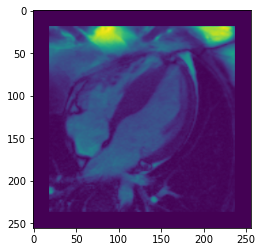

In [50]:
prediction = model.predict(val_images, batch_size = 1)
plt.imshow(val_images[4][:,:,1])

In [31]:
prediction = model.predict(np.expand_dims(val_images[4], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]
scores

[0.1543179154396057, 0.8456821]

In [ ]:
## Stratified K-Cross Validation
skf = m_s.StratifiedKFold(n_splits = 5)
skf.get_n_splits(np_training_images,training_labels)
for train_index, test_index in skf.split(np_training_images,training_labels):
    print("Train Size:", len(train_index), "Validation Size:", len(test_index))
    print("Train Fraction:", sum(training_labels[train_index])/len(train_index))
    print("Val Fraction:", sum(training_labels[test_index])/len(test_index))